Compute a joint monomer contingency table by forming the outer product of the core composition vectors with the corona composition vectors

In [46]:
import data1 as data
import numpy as np

res = 0
for i in range(len(data.polymers)):
    res += np.outer(data.polymers[data.corona_comp].iloc[i], data.polymers[data.core_comp].iloc[i])

res.round()

array([[ 16.,   0.,   0.,  19.,  20.,  20., 154.,  45.,   0.,  25.,   0.,
          0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  49.,   0.,   0.,   0.,   0.,
          0.],
       [  0.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.],
       [  0.,   0.,   0.,   0.,  14.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.],
       [  0.,  58.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,
          0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  41.,   0.,   0.,   0.,   0.,
          0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  22.,   0.,   0.,   0.,   0.,
          0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  11.,   0.,   0.,   0.,   0.,
          0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  47.,   0.,   0.,   0.,   0.,
          0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   8.,   0.,   0.,   0.,   0.,
          0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  19.,   0.,   0.,   0.,   0.,
          0.],
       [  0.,   0.,  

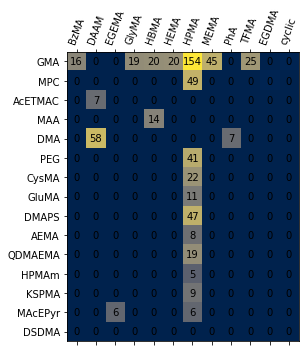

In [50]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from common import OUTPUTPATH

fig, ax = plt.subplots(figsize=(5, 5))
ax = plt.gca()
ax.matshow(np.log2(res+1), cmap='cividis')
for i in range(12):
    for j in range(15):
        c = res[j,i]
        ax.text(i, j, str(round(c)), va='center', ha='center')

ax.xaxis.set_tick_params(rotation=70)
ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(range(12)))
ax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter([s[5:] for s in data.core_comp]))

ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(range(15)))
ax.yaxis.set_major_formatter(mpl.ticker.FixedFormatter([s[7:] for s in data.corona_comp]))

plt.tight_layout()
plt.savefig(os.path.join(OUTPUTPATH, 'monomer_counts.pdf'))
plt.show()